# Notes
- Consider coding implicit method such as SOR for solving vorticity
- The first iteration will have vorticity = 0 because Temperature has only just been updated
# Questions
- For the SOR solver how do we initialise $\Delta \psi$
- How do we solve for the pressure field

# 🧮 Non-Dimensional Incompressible Navier-Stokes Equations (2D, Scalar Form)

#### 🔹 Continuity Equation:
$$
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
$$
#### 🔹 x-Momentum Equation:
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = -\frac{\partial p}{\partial x} + Pr \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
$$
#### 🔹 y-Momentum Equation:
$$
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = -\frac{\partial p}{\partial y} + Pr \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right) + Pr*Ra*T
$$
#### 🔹 Non-Dimensional Heat Equation (with Advection)
$$
\frac{\partial T}{\partial t} + u \frac{\partial T}{\partial x} + v \frac{\partial T}{\partial y} =  \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} 
$$

# 🔁 Vorticity–Streamfunction Form (2D, Non-Dimensional)

#### 1. Vorticity Definition:
$$
\omega = -\frac{\partial v}{\partial x} + \frac{\partial u}{\partial y}
$$

$$
\omega = \nabla^2 \psi = \left( \frac{\partial^2 \psi}{\partial x^2} + \frac{\partial^2 \psi}{\partial y^2} \right)
$$

#### 2. Vorticity Transport Equation (from momentum equations):
$$
\frac{\partial \omega}{\partial t} + u \frac{\partial \omega}{\partial x} + v \frac{\partial \omega}{\partial y} = Pr \left( \frac{\partial^2 \omega}{\partial x^2} + \frac{\partial^2 \omega}{\partial y^2} \right) - Pr \cdot Ra \cdot \frac{\partial T}{\partial x}
$$

#### 3. Streamfunction–Vorticity Relation (Poisson Equation):
$$
\nabla^2 \psi = \omega
$$

#### 4. Scalar Heat Equation:
$$
\frac{\partial T}{\partial t} + u \frac{\partial T}{\partial x} + v \frac{\partial T}{\partial y} = \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2}
$$

In [1]:
# Importing dependencies
import numpy as np
from matplotlib import pyplot as plt
import time
# Defining parameters
N = 61 # 121 # Number of points along x axis
dx = 1.0 / (N - 1) # Grid spacing in x direction
M = 61 # 121 # Number of points along y axis
dy = 1.0 / (M - 1) # Grid spacing in y direction
Ra = 3.5e3 # 2.5e4 # Rayleigh number
Pr = 0.7 # Prandtl number
h = 0.00001 #Time step
beta = 0.4 # relaxation factor for iterative methods to solve algebraic equations
iter = 1500000
'''
For the modified RK4 method, the CFL number has to be smaller than 2*sqrt(2)
The CFL number is defined as:
    CFL = u*dt/dx + v*dt/dy
The maximum velocity is taken to be 1.0
Hence the time step is given by:
    dt = CFL*dx/u = 

'''

# Initialisation at t=0 with boundary conditions
u = np.zeros((N, M)) # x-velocity
v = np.zeros((N, M)) # y-velocity
T = np.zeros((N, M)) # Temperature
rT = np.zeros((N, M)) # Residual temperature
vor = np.zeros((N, M)) # Vorticity
rvor = np.zeros((N, M)) # Residual vorticity
p = np.zeros((N, M)) # Stream function initialised to be 0
rp = np.zeros((N, M)) # Residual stream function
for i in range(N):
    T[i, 0] = 0.5 * np.cos(np.pi * i / (N-1))+1 # Bottom boundary condition of T = 0.5cos(pi*x)+1


# 💡 Solution of Vorticity $\omega_{i,j}^{n+1}$
For solutions of Vorticity and Temperature field in the next time step, we first define ✨residual functions✨ in order to apply our implicit or explicit schemes
## ✨ Creating Vorticity Residual Function (or spatial operator $S(\omega_{i,j})$)
$$
R^\omega =  Pr \left( \frac{\partial^2 \omega}{\partial x^2} + \frac{\partial^2 \omega}{\partial y^2} \right) + Pr \cdot Ra \cdot \frac{\partial T}{\partial x} - u \frac{\partial \omega}{\partial x} - v \frac{\partial \omega}{\partial y}
$$


$$
R^\omega_{i,j} = Pr\left(\frac{\omega_{i-1,j}-2\omega_{i,j}+\omega_{i+1,j}}{\Delta x^2}+\frac{\omega_{i,j-1}-2\omega_{i,j}+\omega_{i,j+1}}{\Delta y^2}\right) + Pr \cdot Ra \cdot \frac{T_{i+1,j} - T_{i-1,j}}{2\Delta x} - u_{i,j} \cdot \frac{\omega_{i+1,j} - \omega_{i-1,j}}{2\Delta x} - v_{i,j} \cdot \frac{\omega_{i,j+1} - \omega_{i,j-1}}{2\Delta y}
$$

## ✨ Creating Temperature Residual Function (or spatial operator $S(T_{i,j})$)
$$
R^T = \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} - u \frac{\partial T}{\partial x} - v \frac{\partial T}{\partial y}
$$

$$
R^T_{i,j} = \frac{T_{i-1,j} - 2T_{i,j} + T_{i+1,j}}{\Delta x^2} + \frac{T_{i,j-1} - 2T_{i,j} + T_{i,j+1}}{\Delta y^2} - u_{i,j} \cdot \frac{T_{i+1,j} - T_{i-1,j}}{2\Delta x} - v_{i,j} \cdot \frac{T_{i,j+1} - T_{i,j-1}}{2\Delta y}
$$


In [ ]:
def resvor(vor):
    rvor = np.zeros_like(vor)
    for i in range(1, N - 1):
        for j in range(1, M - 1):
            dvorx2 = (vor[i+1, j] - 2*vor[i, j] + vor[i-1, j]) / (dx**2)
            dvory2 = (vor[i, j+1] - 2*vor[i, j] + vor[i, j-1]) / (dy**2)
            dvorx1 = u[i, j] * (vor[i+1, j] - vor[i-1, j]) / (2*dx)
            dvory1 = v[i, j] * (vor[i, j+1] - vor[i, j-1]) / (2*dy)
            dTx = (T[i+1, j] - T[i-1, j]) / (2*dx)

            rvor[i, j] = (dvorx2 + dvory2) * Pr - Pr * Ra * dTx - dvorx1 - dvory1
            
    return rvor

def restemp(T):
    rtemp = np.zeros_like(T)
    for i in range(1, N - 1):
        for j in range(1, M - 1):
            dTx2 = (T[i+1, j] - 2*T[i, j] + T[i-1, j]) / (dx**2)
            dTy2 = (T[i, j+1] - 2*T[i, j] + T[i, j-1]) / (dy**2)
            dTx1 = u[i, j] * (T[i+1, j] - T[i-1, j]) / (2*dx)
            dTy1 = v[i, j] * (T[i, j+1] - T[i, j-1]) / (2*dy)

            rtemp[i, j] = dTx2 + dTy2 - dTx1 - dTy1
            
    return rtemp

# 🚶🏻‍➡️ Explicit Euler or Runge-Kutta 4 for Vorticity, $\omega_{i,j}$ (and similarly for Temperature $T_{i,j}$)

## 🔹 Explicit Euler Scheme:
$$
\omega^{n+1}_{i,j} = \omega^n_{i,j} + \Delta t \cdot R^{n}_{i,j}
$$

## 🔹 Explicit Runge-Kutta 4 (RK4) Scheme (Modified proposed by James):
1. Compute intermediate stages:
    $$  
    k_1 = 0.25 \cdot \Delta t \cdot R(\omega^n_{i,j})
    $$
    $$
    k_2 = \frac{\Delta t}{3} \cdot R\left(\omega^n_{i,j} + k_1\right)
    $$
    $$
    k_3 = 0.5 \cdot \Delta t \cdot R\left(\omega^n_{i,j} + k_2\right)
    $$
2. Update:
    $$
    \omega^{n+1} = \Delta t \cdot R\left(\omega^n_{i,j} + k_3\right)
    $$

## 🔹 Point Jacobi Relaxation Method:
1. Compute the coefficient for the central point:
    $$
    a_p = \left(\frac{2}{\Delta x^2} + \frac{2}{\Delta y^2}\right) + \frac{1}{\Delta t}
    $$
2. Update the temperature field iteratively:
    $$
    \omega_{i,j}^{n+1} = \omega_{i,j}^n + \beta \cdot \frac{R^\omega_{i,j}}{a_p}
    $$
   where $\beta$ is the relaxation factor to ensure convergence.
3. Perform this update for all interior points \( i, j \) while keeping the boundary conditions fixed.


In [3]:
def solT(rT, method="euler"):
    
    if method == "euler":
        T[1:N-1, 1:M-1] += h * rT[1:N-1, 1:M-1]
    
    elif method == "rk4_modified":
        Ti = np.copy(T)
        # 1st stage
        Ti[1:N-1, 1:M-1] = T[1:N-1, 1:M-1] + 0.25 * h * rT[1:N-1, 1:M-1]
        # 2nd stage
        rT = restemp(Ti)
        Ti[1:N-1, 1:M-1] = T[1:N-1, 1:M-1] + (h / 3.0) * rT[1:N-1, 1:M-1]
        # 3rd stage
        rT = restemp(Ti)
        Ti[1:N-1, 1:M-1] = T[1:N-1, 1:M-1] + 0.5 * h * rT[1:N-1, 1:M-1]
        # 4th stage
        rT = restemp(Ti)
        T[1:N-1, 1:M-1] += h * rT[1:N-1, 1:M-1]

    elif method == 'Point Jacobi':
        a_p_T = (2/dx**2 + 2/dy**2) + 1/h
        for i in range(1, N - 1):
            for j in range(1, M - 1):
                T[i, j] += beta * rT[i, j] / a_p_T

    return T

def solvor(rvor, method="euler"):

    if method == "euler":
        vor[1:N-1, 1:M-1] += h * rvor[1:N-1, 1:M-1]
    
    elif method == "rk4_modified":
        vori = np.copy(vor)

        # 1st stage
        vori[1:N-1, 1:M-1] = vor[1:N-1, 1:M-1] + 0.25 * h * rvor[1:N-1, 1:M-1]
        # 2nd stage
        rvor = resvor(vori)
        vori[1:N-1, 1:M-1] = vor[1:N-1, 1:M-1] + (h / 3.0) * rvor[1:N-1, 1:M-1]
        # 3rd stage
        rvor = resvor(vori)
        vori[1:N-1, 1:M-1] = vor[1:N-1, 1:M-1] + 0.5 * h * rvor[1:N-1, 1:M-1]
        # 4th stage
        rvor = resvor(vori)
        vor[1:N-1, 1:M-1] += h * rvor[1:N-1, 1:M-1]
    
    elif method == 'Point Jacobi':
        a_p_vor = Pr * (2/dx**2 + 2/dy**2) + 1/h
        for i in range(1, N - 1):
            for j in range(1, M - 1):
                vor[i, j] += beta * rvor[i, j] / a_p_vor
        
    return vor

# 💡 Solution of Stream function $\psi_{i,j}^{n+1}$ 

$$
\nabla^2 \psi = \frac{\partial^2 \psi}{\partial x^2} + \frac{\partial^2 \psi}{\partial y^2} = \omega
$$

$$
\frac{\psi_{i-1,j}^{n+1} - 2\psi_{i,j}^{n+1} + \psi_{i+1,j}^{n+1}}{\Delta x^2} + \frac{\psi_{i,j-1}^{n+1} - 2\psi_{i,j}^{n+1} + \psi_{i,j+1}^{n+1}}{\Delta y^2} = \omega_{i,j}^{n+1}
$$


## 🔹 Point Jacobi Relaxation solver (implicit method):

1. Calculate residual of the Poisson equation
    $$
    S_{i,j}^n = \omega_{i,j}^{n+1} - \left(\frac{\psi_{i-1,j}^{n} - 2\psi_{i,j}^{n} + \psi_{i+1,j}^{n}}{\Delta x^2} + \frac{\psi_{i,j-1}^{n} - 2\psi_{i,j}^{n} + \psi_{i,j+1}^{n}}{\Delta y^2}\right )
    $$
2. Calculate coefficients
    $$
    b_W = \frac{1}{\Delta x^2}\\
    $$
    $$
    b_E = b_W\\
    $$
    $$
    b_S = \frac{1}{\Delta y^2}\\
    $$
    $$
    b_N = b_S\\
    $$
    $$
    b_P = 2 (b_W + b_S)
    $$
3. Calculate $\psi_{i,j}^{n+1}$:
    $$
    b_P \cdot \Delta \psi_{i,j}^{n+1} = S_{i,j}^n\\
    $$
    $$
    \psi_{i,j}^{n+1} = \psi_{i,j}^{n} + \beta \cdot \Delta \psi_{i,j}^{n+1}
    $$

In [4]:
# Calculation of residual of the Poisson equation
def resp(p):
    rp = np.zeros_like(p)
    
    for i in range(2, N-2):
        for j in range(2, M-2):
            rp[i, j] = vor[i, j] - (
                (p[i+1, j] - 2*p[i, j] + p[i-1, j]) / (dx**2) +
                (p[i, j+1] - 2*p[i, j] + p[i, j-1]) / (dy**2)
            )
    
    return rp

def solp(rp, beta):
    # Coefficients for iterative methods
    b_W = 1 / dx**2
    b_S = 1 / dy**2
    b_P = -2 * (b_W + b_S)
    
    for i in range(2, N-2):
        for j in range(2, M-2):
            p[i, j] += beta * rp[i, j] / b_P

    # # Update p at the boundaries
    # p[0, :] = 0 #Left
    # p[N - 1, :] = 0 #Right
    # p[:, 0] = 0 #Bottom
    # p[:, M - 1] = 0 #Top
            
    return p

# 💡 Solution of Temperature field $T_{i,j}^{n+1}$

Calculate $T_{i,j}^{n+1}$ using Euler explicit scheme

$$
T^{n+1}_{i,j} = T^n_{i,j} + \Delta t \cdot R^T_{i,j}
$$

Function to step in time for the Temperature field already defined in the ***step*** function by simply calling ***step(T, method="euler", ResFunction=restemp)***

# 🔄 Updating of stream function $\psi_{2,j}, \psi_{M-2,j}, \psi_{i,2}, \psi_{i,N-2}$ (we assume that $\psi = \frac{\partial \psi}{\partial x} = \frac{\partial \psi}{\partial y} = 0$ at the boundary)

## 🔹 Updating stream function $\psi$ at the boundary
$$
\psi_{2,j} = \frac{1}{4} \psi_{3,j}
$$
$$
\psi_{N-1,j} = \frac{1}{4} \psi_{N-2,j}
$$
$$
\psi_{i,2} = \frac{1}{4} \psi_{i,3}
$$
$$
\psi_{i,M-2} = \frac{1}{4} \psi_{i,M-2}
$$

In [5]:
def BCp(p):
    # Update p along the vertical boundaries
    for j in range(2, M-2):  
        p[1, j] = 0.25 * p[2, j]  #Left
        p[N - 2, j] = 0.25 * p[N - 3, j]  #Right

    # Update p along the horizontal boundaries
    for i in range(2, N-2):  
        p[i, 1] = 0.25 * p[i, 2] #Bottom
        p[i, M - 2] = 0.25 * p[i, M - 3] #Top

    # Update p at the boundaries
    p[0, :] = 0 #Left
    p[N - 1, :] = 0 #Right
    p[:, 0] = 0 #Bottom
    p[:, M - 1] = 0 #Top

    return p

# 🔄 Updating of the vorticity function at the boundary $\omega_{1,j}, \omega_{M,j}, \omega_{i,1}, \omega_{i,N}$

## 🔹 $2^{nd}$ order approximation
$$
\omega_{1,j} = \frac{3\psi_{2,j}}{\Delta x^2} - \frac{1}{2}\omega_{2,j} 
$$
$$
\omega_{N,j} = \frac{3\psi_{N-1,j}}{\Delta x^2} - \frac{1}{2}\omega_{N-1,j} 
$$
$$
\omega_{i,1} = \frac{3\psi_{i,2}}{\Delta y^2} - \frac{1}{2}\omega_{i,2} 
$$
$$
\omega_{i,M} = \frac{3\psi_{i,M-1}}{\Delta y^2} - \frac{1}{2}\omega_{i,M-1}
$$

In [6]:
def BCvor(vor):
    # Update vorticity at the boundaries using 2nd order approximation
    for j in range(M):
        vor[0, j] = 3.0 * p[1, j] / (dx**2) - 0.5 * vor[1, j]
        vor[N-1, j] = 3.0 * p[N-2, j] / (dx**2) - 0.5 * vor[N-2, j]
    
    # Update along the horizontal boundaries (i-loop)
    for i in range(1, N-1):
        vor[i, 0] = 3.0 * p[i, 1] / (dy**2) - 0.5 * vor[i, 1]
        vor[i, M-1] = 3.0 * p[i, M-2] / (dy**2) - 0.5 * vor[i, M-2]
    
    return vor  

# 🔄 Updating of the Temperature function at the left and right boundary $T_{1,j}, T_{N,j}$
## 🔹 $2^{nd}$ order approximation
We know the ***one-sided*** second order Taylor approximation of the first order derivative to be
$$
\frac{\partial T}{\partial x} \bigg|_{1,j} = \frac{-3T_{1,j} + 4T_{2,j} - T_{3,j}}{2\Delta x} + O(\delta x^2)
$$
$$
\frac{\partial T}{\partial x} \bigg|_{N,j} = \frac{3T_{N,j} - 4T_{N-1,j} + T_{N-2,j}}{2\Delta x} + O(\delta x^2)
$$
And since $\frac{\partial T}{\partial x} \bigg|_{N,j} = \frac{\partial T}{\partial x} \bigg|_{1,j} = 0$ the updating of Temperature field at the left and right boundaries become:
$$
T_{1,j} = \frac{4}{3}T_{2,j} -\frac{1}{3}T_{3,j}
$$
$$
T_{N,j} = \frac{4}{3}T_{N-1,j} - \frac{1}{3}T_{N-2,j}
$$
## 🔹 Temperature at the top boundary $T_{i, N} = 0$
We need to force the temperature at the top boundary to be 0 otherwise the solution would not be fully constrained and it would diverge.
$$
T_{i,N} = 0
$$
```

In [7]:
def BCT(T):
    # Update temperature at the left boundary
    for j in range(M):
        T[0, j] = (4/3) * T[1, j] - (1/3) * T[2, j]
    
    # Update temperature at the right boundary
    for j in range(M):
        T[N-1, j] = (4/3) * T[N-2, j] - (1/3) * T[N-3, j]

    # Update temperature at the top boundary (added: isothermal condition T=0)
    for i in range(N):
        T[i, N-1] = 0.0
    
    return T

# 🧮 Calculating Back the Velocity Components from the Stream Function
$$
u = \frac{\partial \psi}{\partial y} \approx \frac{\psi_{i,j+1} - \psi_{i,j-1}}{2\Delta y}
$$
$$
v = -\frac{\partial \psi}{\partial x} \approx - \left(\frac{\psi_{i+1,j} - \psi_{i-1,j}}{2\Delta x}\right)
$$

In [8]:
def caluv(u,v,p):
    # Apply physical boundary conditions of 0 velocity
    for j in range(M):
        u[0, j] = 0
        u[N-1, j] = 0
        v[0, j] = 0
        v[N-1, j] = 0

    for i in range(1, N-1):
        u[i, 0] = 0
        v[i, 0] = 0
        u[i, M-1] = 0
        v[i, M-1] = 0

    # Update velocity components based on stream function
    for i in range(1, N-1):
        for j in range(1, M-1):
            u[i, j] = 0.5 * (p[i, j+1] - p[i, j-1]) / dy
            v[i, j] = 0.5 * (p[i-1, j] - p[i+1, j]) / dx

# 🚀 Implementing numerical pipeline till convergence error less than 1e-4

This section initializes the convergence criteria and iteratively solves the coupled equations for vorticity, stream function, and temperature fields until the error metrics (`errvor` and `errp`) fall below a specified threshold (1e-4). 

- `errvor` and `errp` are initialized to infinity (`np.inf`) to ensure the loop starts.
- The `for` loop iterates up to a maximum number of iterations (`iter`), updating the fields at each step using the specified numerical methods.
- Residuals for vorticity and temperature are computed and used to update the respective fields.
- Boundary conditions for vorticity, stream function, and temperature are enforced after each update.
- Velocity components (`u` and `v`) are recalculated from the stream function.
- The L2 norms of the residuals (`errvor` and `errp`) are computed to monitor convergence.
- The loop prints progress every 2000 iterations and records the total simulation time.

This iterative process ensures the solution converges to a steady state within the specified error tolerance.
```

In [9]:
# Initialise errvor and errp for convergence check to be infinity
errp = np.inf
errvor = np.inf
errT = np.inf
iter_no = 0
# Function to update the heatmap for each frame
# while errp > 1e-4 and errvor > 1e-4:

start_time = time.time()

for _ in range(iter):

    # Compute residual vorticity in place and update vorticity
    rvor = resvor(vor)
    vor = solvor(rvor, method="euler")

    # Compute residual Poisson equation in place and update stream function
    rp = resp(p)
    p = solp(rp, beta)

    # Update boundary conditions for stream function
    p = BCp(p)

    # Update boundary conditions for vorticity
    vor = BCvor(vor)

    # Update velocity components in place based on stream function
    caluv(u, v, p)

    # Compute residual temperature in place and update temperature
    rT = restemp(T)
    T = solT(rT, method="euler")

    # Update Temprature field
    T = BCT(T)

    # Update iteration number
    iter_no += 1

    errvor = np.sqrt(np.sum(rvor**2))
    errp = np.sqrt(np.sum(rp**2))
    errT = np.sqrt(np.sum(rT**2))

    if iter_no % 1000 == 0:
        print('Iteration number', iter_no, "errp: ", errp, "errvor: ", errvor, "errT: ", errT)
    
end_time = time.time()
total_time = end_time - start_time

print('My time step is:', h)
print('Total time elapsed is:', h*iter)
print('Total time taken for the simulation:', total_time, 'seconds')

KeyboardInterrupt: 

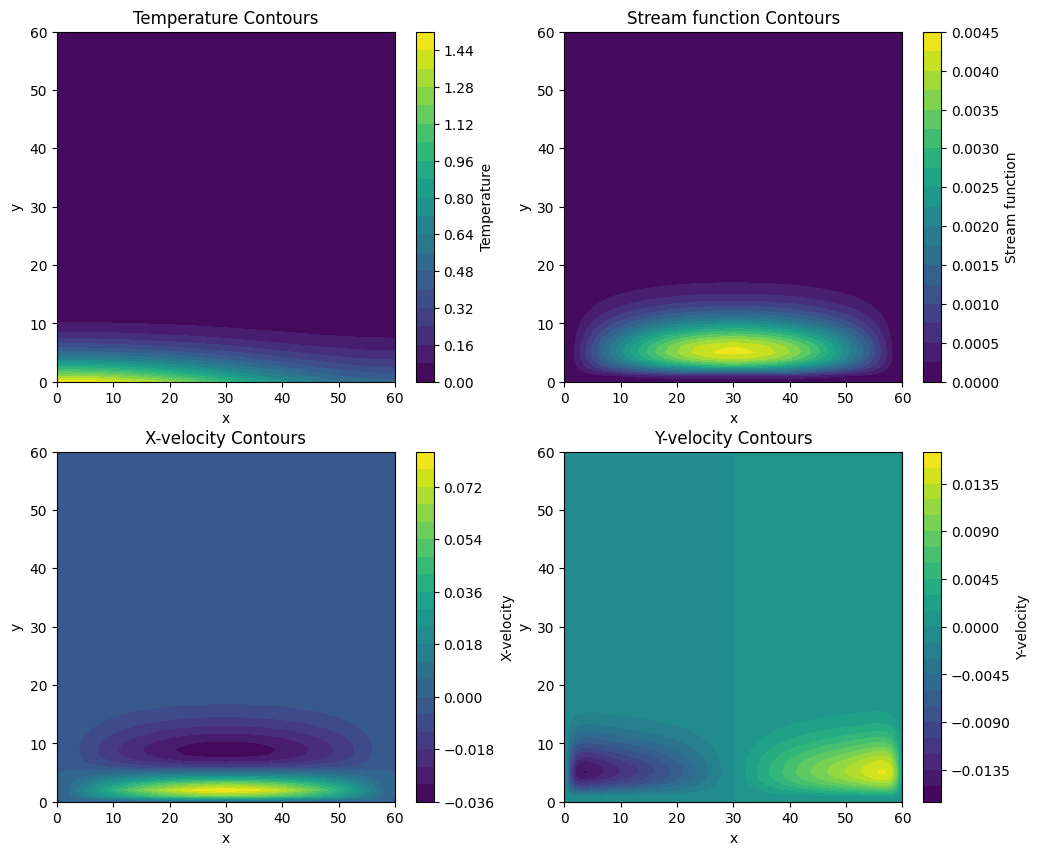

In [10]:
# Create 2x2 grid and plot contours for T, p, u, and v
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# Plot Temperature contours 
contour1 = axes[0, 0].contourf(T.T, levels=20, cmap='viridis')
axes[0, 0].set_title("Temperature Contours")
axes[0, 0].set_xlabel("x")
axes[0, 0].set_ylabel("y")
fig.colorbar(contour1, ax=axes[0, 0], label="Temperature")
# Plot Stream function contours
contour2 = axes[0, 1].contourf(p.T, levels=20, cmap='viridis')
axes[0, 1].set_title("Stream function Contours")
axes[0, 1].set_xlabel("x")
axes[0, 1].set_ylabel("y")
fig.colorbar(contour2, ax=axes[0, 1], label="Stream function")
# Plot X-velocity contours
contour3 = axes[1, 0].contourf(u.T, levels=20, cmap='viridis')
axes[1, 0].set_title("X-velocity Contours")
axes[1, 0].set_xlabel("x")
axes[1, 0].set_ylabel("y")
fig.colorbar(contour3, ax=axes[1, 0], label="X-velocity")
# Plot Y-velocity contours
contour4 = axes[1, 1].contourf(v.T, levels=20, cmap='viridis')
axes[1, 1].set_title("Y-velocity Contours")
axes[1, 1].set_xlabel("x")
axes[1, 1].set_ylabel("y")
fig.colorbar(contour4, ax=axes[1, 1], label="Y-velocity")

# March in time till $R^T_{i,j}$ and $R_{i,j}$ or $S_{i,j}$ less than a certain value
- Take the $L_{2}$ norm of these flattened vectors 